Starting analysis for topology: random_20N

Processing Configuration: random_20N / stable
  Found 1000 simulation runs (seeds). Processing...
  Processed 1000 runs: Found 1000 valid PDR logs and 1000 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.7201
  Std. Dev. of PDR (run-to-run): 0.2194
  (Based on 1000 simulation runs)


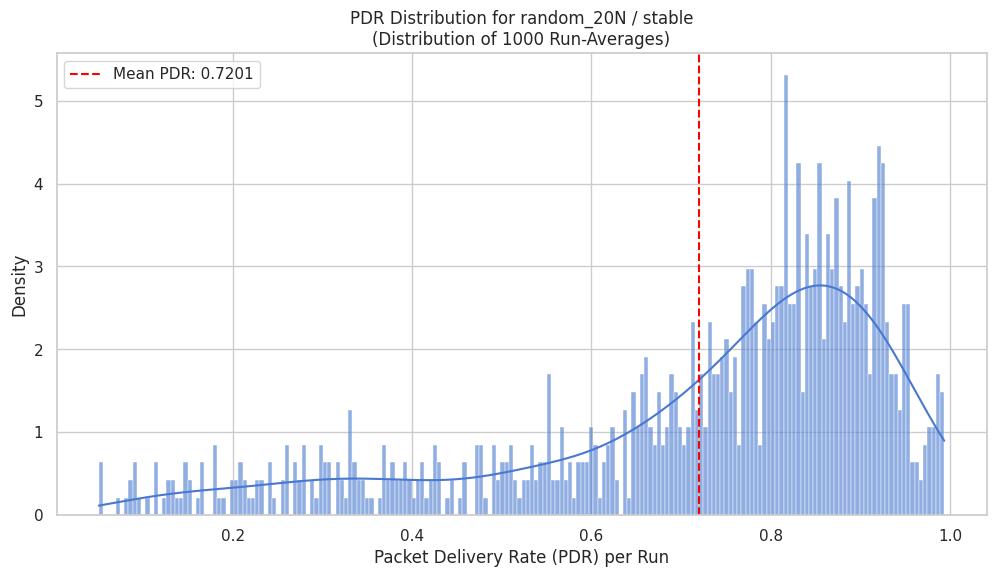


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 8.8576 s
  Std. Dev. of Latency (all packets): 72.5184 s
  (Based on 801109 total packets delivered across all runs)


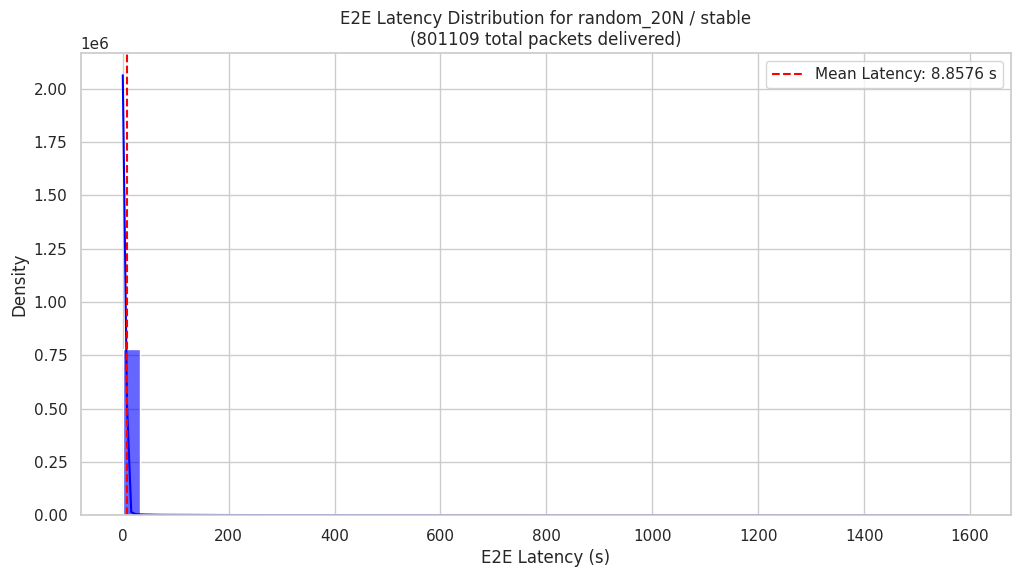



Analysis complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251112_19-11-56")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "random_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")

Starting analysis for topology: random_20N

Processing Configuration: random_20N / stable
  Found 1000 simulation runs (seeds). Processing...
  Processed 1000 runs: Found 1000 valid PDR logs and 1000 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.7276
  Std. Dev. of PDR (run-to-run): 0.2127
  (Based on 1000 simulation runs)


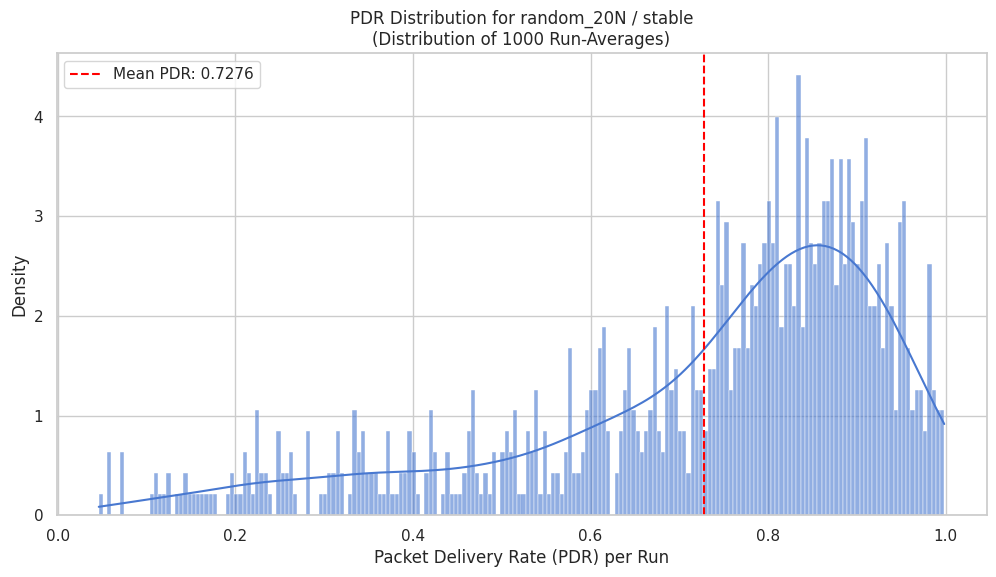


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 8.7589 s
  Std. Dev. of Latency (all packets): 72.0221 s
  (Based on 809499 total packets delivered across all runs)


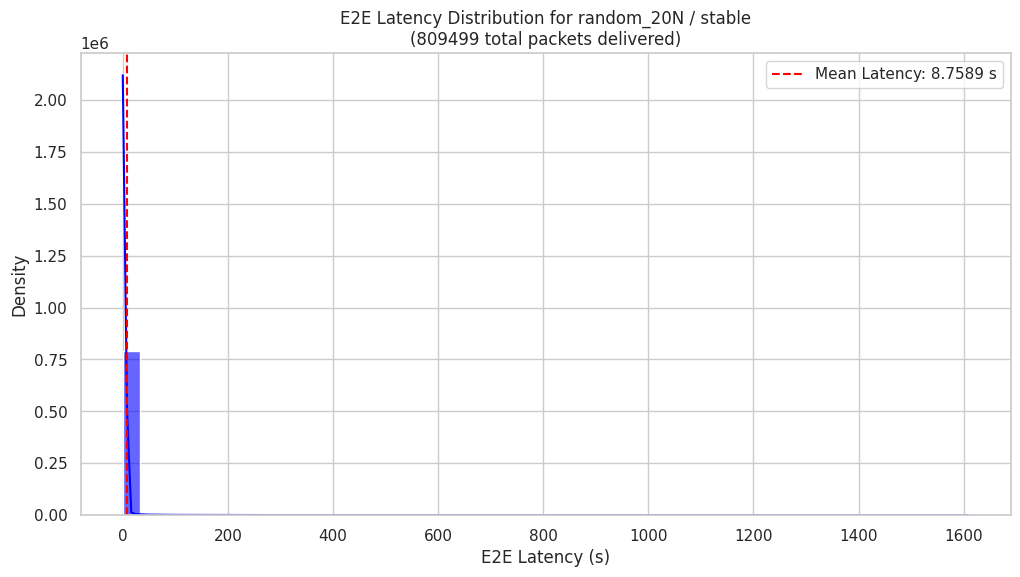



Analysis complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251113_09-10-05")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "random_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")

Starting analysis for topology: random_20N

Processing Configuration: random_20N / stable
  Found 1000 simulation runs (seeds). Processing...
  Processed 1000 runs: Found 1000 valid PDR logs and 1000 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.8173
  Std. Dev. of PDR (run-to-run): 0.1789
  (Based on 1000 simulation runs)


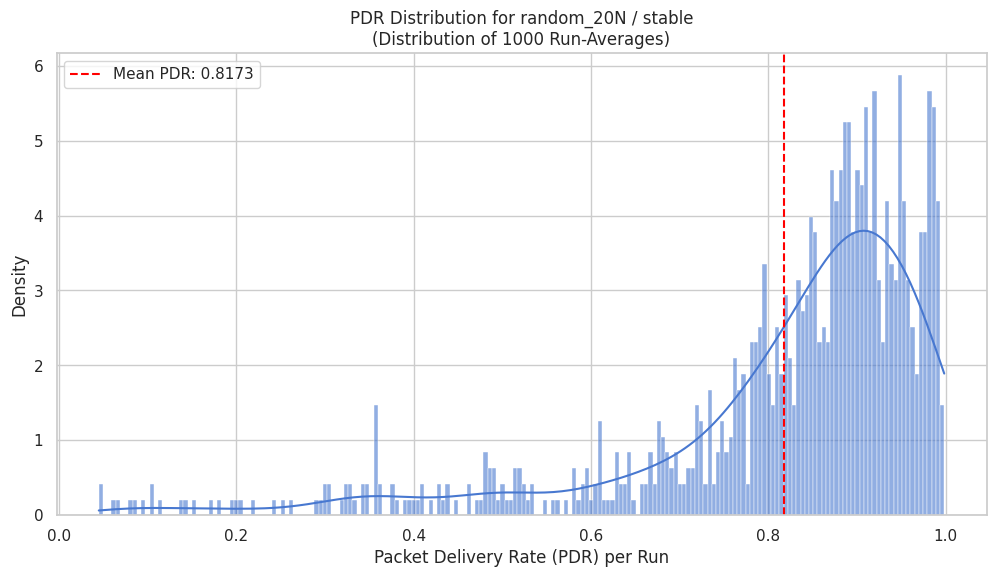


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 6.0748 s
  Std. Dev. of Latency (all packets): 60.0200 s
  (Based on 912660 total packets delivered across all runs)


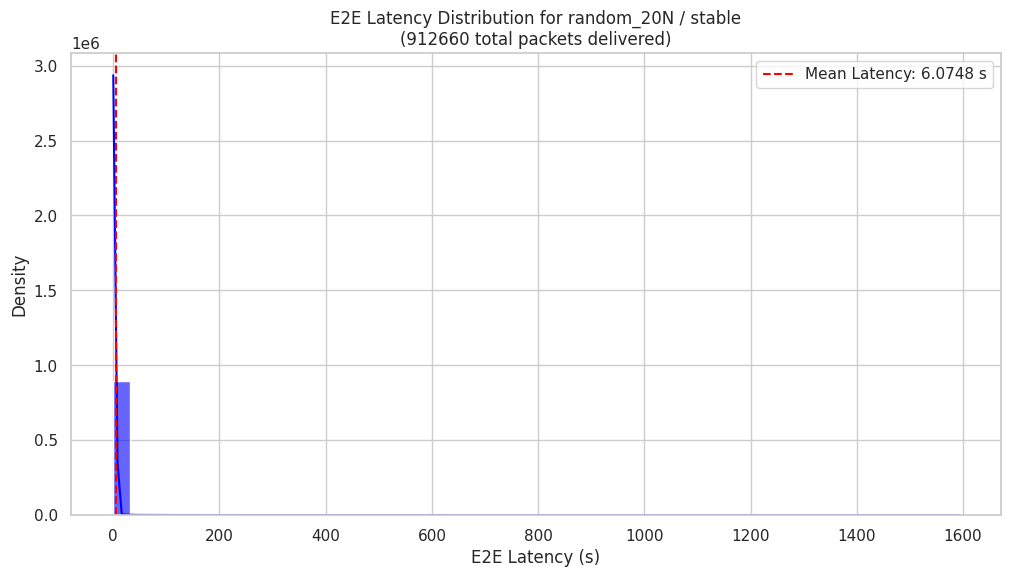



Analysis complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251113_21-02-52")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "random_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")